# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Требуется построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
! pip install -U scikit-learn -q
! pip install matplotlib==3.7.3 -q
! pip install phik -q

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [2]:
# импортируем необходимые библиотеки:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# загружаем функцию для работы с метриками
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer
# импортируем класс:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from phik import phik_matrix
from phik.report import plot_correlation_matrix

import time

import warnings 
warnings.filterwarnings('ignore')

import catboost
from catboost import CatBoostRegressor, Pool, cv
import lightgbm as lgb
from lightgbm import LGBMRegressor

### Загрузка и обработка данных

In [3]:
autos = pd.read_csv ('/datasets/autos.csv')
display(autos.head())
autos.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Всего 354 369 строк и 16 признаков. Признаки тип автомобильного кузова "VehicleType", тип коробки передач "Gearbox", модель автомобиля "Model", тип топлива "FuelType" и была машина в ремонте или нет "Repaired" содержат пропуски. 

Также признакам дата скачивания анкеты из базы "DateCrawled", дата создания анкеты "DateCreated" и дата последней активности пользователя "LastSeen" больше подходит тип данных дата:         

In [4]:
autos.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [5]:
# изменим типы данных:
autos [['DateCrawled', 'DateCreated', 'LastSeen']] = autos [['DateCrawled', 'DateCreated', 'LastSeen']].astype('datetime64[ns]')

Удалим неинформативные признаки - дата скачивания анкеты из базы "DateCrawled" и почтовый индекс владельца анкеты (пользователя) "PostalCode":

In [6]:
autos = autos.drop (['PostalCode'], axis =1)

Отсутствие данных в признаке "Repaired" вероятно связан с отсутствием ремонтов у машины. Заменим пропуски в данном столбце на "no":

In [7]:
autos ['Repaired'] = autos ['Repaired'].fillna ('no')

Пропуски в признаке "Model" заполним заполним наиболее часто встречающейся моделью такого же бренда.

In [8]:
def mode(series):
    return series.mode().iloc[0] if not series.mode().empty else None

grouped_autos = autos.groupby('Brand')['Model'].agg(mode)

for brand, model in grouped_autos.items():
    autos.loc[((autos['Brand'] == brand) & (autos['Model'].isna())), 'Model'] = model

In [9]:
#проверим остались ли пропуски в признаке  "Model":
autos['Model'].isna().sum()

3374

Оставшиеся пропуски в признаке "Model" заполним на 'unknown':

In [10]:
autos ['Model'] = autos ['Model'].fillna ('unknown')

In [11]:
autos ['Model'].isna().sum()

0

Пропуски в остальных признаках заполним наиболее часто встречающимся значением у автомобилей той же модели:

In [12]:
for f in ['VehicleType', 'Gearbox', 'FuelType']:
    grouped_autos = autos.groupby('Model')[f].agg(mode)
    for model, feat in grouped_autos.items():
        autos.loc[((autos['Model'] == model) & (autos[f].isna())), f] = feat
    

In [13]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        354369 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            354369 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              354369 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           354369 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           354369 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [14]:
# проверим заполнение категориальных признаков на наличие неявных дубликатов:
cat_col = autos.select_dtypes(include=['object']).columns.to_list()
for col in cat_col: 
    print(f'Значения категориального признака {col}: {autos[col].unique()}')

Значения категориального признака VehicleType: ['sedan' 'coupe' 'suv' 'small' 'convertible' 'bus' 'wagon' 'other']
Значения категориального признака Gearbox: ['manual' 'auto']
Значения категориального признака Model: ['golf' 'a4' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'unknown' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito'
 'sprinter' '156' 'escort' 'forester' 'xc_reihe' 'scenic' 'a1' 'insignia'
 'combo' 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100'
 'z_reihe' 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran'
 'getz' 'a3' 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo'
 'cordoba' 'colt' 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe'
 'espace' 'sharan' '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe'
 'yeti' 'octavi

Неявные дубликаты не выявлены.

Посмотрим на описание количественных признаков:

In [15]:
autos.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,LastSeen
count,354369,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369,354369.0,354369
mean,2016-03-21 12:58:10.450648320,4416.656776,2004.234448,110.094337,128211.172535,5.714645,2016-03-20 19:12:07.753274112,0.0,2016-03-29 23:51:00.667456768
min,2016-03-05 14:06:22,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,2016-04-03 15:15:51
75%,2016-03-29 14:37:20,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,2016-04-07 14:58:51
std,NaN,4514.158514,90.227958,189.850405,37905.341530,3.726421,NaN,0.0,NaN


Признак количество фотографий автомобиля "NumberOfPictures" у всех строк = 0. Данный столбец также не несет никакой информации, поэтому его также удаляем.

In [16]:
autos['NumberOfPictures'].value_counts()

NumberOfPictures
0    354369
Name: count, dtype: int64

In [17]:
autos = autos.drop ('NumberOfPictures', axis =1)
autos.sample()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,LastSeen
48464,2016-03-29 21:51:20,2650,small,2003,manual,83,jazz,150000,8,petrol,honda,no,2016-03-29,2016-04-02 11:15:24


Признаки цена (евро) "Price", год регистрации автомобиля "RegistrationYear", мощность (л. с.) "Power" и месяц регистрации автомобиля "RegistrationMonth" имеют аномальные значения, в том числе и нулевые. Рассмотрим их по отдельности.

Посмотрим на графике распределение цен на автомобили:

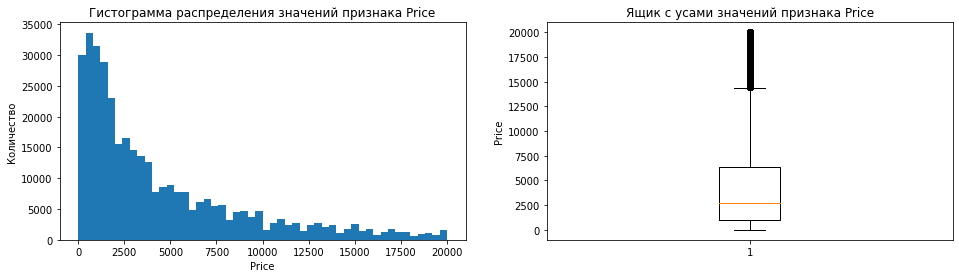

In [18]:
def pic(features):
    figure, axis = plt.subplots(1, 2)
    figure.set_figheight(4)
    figure.set_figwidth(16)

    axis[0].hist(features, bins = 50)
    axis[0].set_title(f'Гистограмма распределения значений признака {features.name}') 
    axis[0].set_xlabel(f'{features.name}') 
    axis[0].set_ylabel('Количество') 
  
    axis[1].boxplot(features) 
    axis[1].set_title (f'Ящик с усами значений признака {features.name}') 
    axis[1].set_ylabel(f'{features.name}') 
    return plt.show() 

pic(autos['Price'])

Графики показывают, что достаточно много аномально низких значений, близких к 0, а также присутствуют нестандартно высокие значения. Т.к. аномалии в дальнейшем могут исказить прогнозы, удалим их, оставив значения от 20% квантиля.

In [19]:
autos = autos.query ('Price.quantile(0.20) <= Price')
print('Размер данных после удаления аномалий признака цены:', autos.shape)

Размер данных после удаления аномалий признака цены: (283580, 14)


Признак год регистрации автомобиля **"RegistrationYear"** также содержит нереальные значения.

In [20]:
np.array(sorted(autos['RegistrationYear'].unique()))

array([1000, 1001, 1039, 1234, 1400, 1500, 1600, 1800, 1910, 1923, 1925,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2500, 2800, 2900, 3000, 3200, 3700, 4000,
       4100, 4500, 5000, 5555, 5911, 6000, 7000, 7100, 7800, 8500, 8888,
       9000, 9999])

In [21]:
autos['RegistrationYear'].quantile(0.01)

1979.0

Автомобили, выпущенные ранее 1980 года составляют менее 1 % оставшихся данных, таким образом, можно удалить их без потери количества.  

Посмотрим на дату выгрузки анкет:

In [22]:
np.array(sorted((pd.DatetimeIndex(autos['DateCrawled']).year).unique())) 

array([2016])

In [23]:
autos['RegistrationYear'].quantile(0.95)

2016.0

Анкеты были скачены из базы в 2016 году, соответственно в них не могло оказаться автомобилей, зарегистрированных после 2016 года, еще 5% данных придется удалить в связи с их недостоверностью.

In [24]:
autos = autos.query ('RegistrationYear.quantile(0.01) < RegistrationYear <= 2016')
print('Размер данных после удаления аномалий признака регистрации автомобиля:', autos.shape)

Размер данных после удаления аномалий признака регистрации автомобиля: (269401, 14)


Признак мощности (л. с.) **"Power"** также имеет аномальные, в том числе и нулевые значения. Посмотрим на графике распределение мощности (л. с.) **"Power"** автомобилей:

In [25]:
# удалим строки с нереально высоким признаком мощности автомобиля
autos = autos[autos['Power'] < 1000]
autos.shape

(269205, 14)

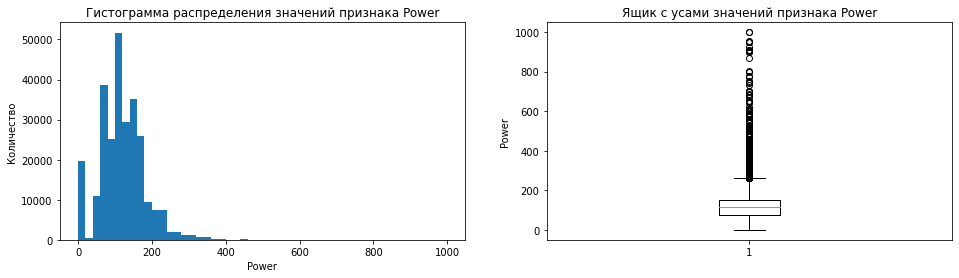

In [26]:
# посмотри на распределение оставшихся данных
pic(autos['Power'])

Значения свыше 400 л.с. являются также редкими и выбивающимися, поэтому удалим их тоже. Мощность автомобил ниже 40 л.с. также маловероятна, строки с таким значением также удалим.

In [27]:
autos = autos.query('40 <= Power <= 400')
print('Размер данных после аномалий признака мощности автомобиля:', autos.shape)

Размер данных после аномалий признака мощности автомобиля: (248727, 14)


Признак пробега (км) **"Kilometer"** имеет отличные от нуля значения и принимает допустимые значения от 5000 до 150000 км. Также примем допущение в виде нереального значения = 0 у признака месяц регистрации автомобиля **"RegistrationMonth"**, т.к. маловероятно, что он имеет значимое влияние на целевой признак цены автомобиля.

In [28]:
#прoверим на наличие дубликатов и удалим их при наличии:
print('Кол-во дубликатов:', autos.duplicated().sum())
autos = autos.drop_duplicates()
print('Размер данных после удаления дубликатов:', autos.shape)

Кол-во дубликатов: 6
Размер данных после удаления дубликатов: (248721, 14)


Посмотрим на итоговое распределение количественных признаков:

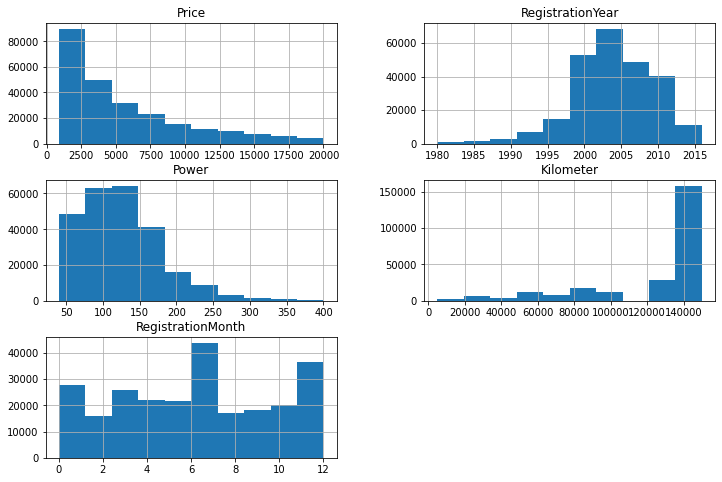

In [29]:
autos.select_dtypes(include=['int']).hist(bins=10, figsize=(12, 8));

В результате проведенной предобработки исходный размер данных уменьшился до 246 812 строк и 14 признаков.

### Корреляционный анализ данных

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']


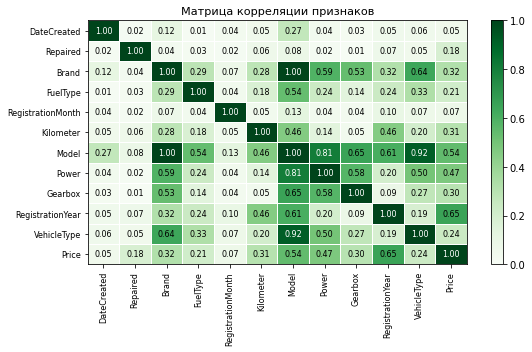

In [30]:
# посмотрим на матрицу корреляции на графике
phik_overview = phik_matrix(autos.drop(['DateCrawled', 'LastSeen'], axis=1))
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции признаков',
    fontsize_factor=0.8,
    figsize=(8, 5)
) 

Мультиколлинеарность (значения коэффициентов корреляции от 0.9 до 1.00 по модулю) оставшихся входных признаков наблюдается у признака "Model" с признаками "Brand" и "VehicleType". В связи с тем, что у признака "Model" присутсвуют отсутствующие значения, но при этом модель автомобиля может оказывать существенное влияние на цену автомобиля, удалять признаки пока не будем. 

На целевой признак цена (евро) ("Price") наибольшее влияние оказывает год регистрации автомобиля ("RegistrationYear"), также заметное влияние оказывают модель автомобиля ("Model") и мощность (л. с.) ("Power"). Практически не имеют влияния на целевой признак цены в евро признаки дата создания анкеты ("DateCreated") и месяц регистрации автомобиля ("RegistrationMonth").

Удалим признаки, содержащие типы данных дата, из датасета моделирования, так как они не являются существенными признаками.

In [31]:
autos_df = autos.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis =1)
autos_df.shape

(248721, 11)

Таким образом, данные для моделиррования состоят из 248 721 строки и 11 признаков.

## Обучение моделей

### Подготовка данных для обучения моделей

Создадим пайплайны для кодирования категориальных признаков и масштабирования количественных.

In [32]:
# разделим столбцы на подходящие им типы кодирования
num_сol = autos_df.drop ('Price', axis =1).select_dtypes(include=['int64']).columns.to_list()
ohe_col = ['Gearbox', 'Repaired']
ord_col = ['VehicleType', 'Model', 'FuelType', 'Brand']

In [33]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: 
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))]

)
# создаём пайплайн для подготовки признаков из списка ord_columns: 
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [34]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_col),
     ('ord', ord_pipe, ord_col),
     ('num', MinMaxScaler(), num_сol)
    ], 
    remainder='passthrough'
)

In [35]:
# выделим из тренировочной и тестовой входные признаки и целевой признак:
X = autos_df.drop ('Price', axis =1)
y = pd.Series(autos_df['Price'])
# разделение на тренировочную и тестовую выборки
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE, test_size = 0.2)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, random_state=RANDOM_STATE)
print('Размер тренировочной выборки =', X_train.shape[0], 'строк')
print('Размер валидационной выборки =', X_valid.shape[0], 'строк')
print('Размер тестовой выборки =', X_test.shape[0], 'строк')

Размер тренировочной выборки = 149232 строк
Размер валидационной выборки = 49744 строк
Размер тестовой выборки = 49745 строк


### Обучение моделей линейной регрессии, регрессии дерева решений, LightGBM и CatBoostRegressor

#### Модель линейной регрессии

In [36]:
# создаём пайплайн для обучения модели линейной регрессии: 
pipe_linal = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid_linal = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [37]:
# подберем лучшие параметры для линейной регрессии:
r_linal = RandomizedSearchCV(
    pipe_linal, 
    param_grid_linal, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [38]:
%%time

r_linal.fit(X_train, y_train)

print('Лучшие параметры модели линейной регрессии:\n\n', r_linal.best_params_)
print()
print ('Метрика лучшей модели линейной регрессии на тренировочной выборке:', np.abs(r_linal.best_score_))

Лучшие параметры модели линейной регрессии:

 {'preprocessor__num': 'passthrough', 'models': LinearRegression()}

Метрика лучшей модели линейной регрессии на тренировочной выборке: 2828.831299949893
CPU times: user 11.7 s, sys: 2.88 s, total: 14.5 s
Wall time: 14.6 s


Модель линейной регресии показало RMSE = 2829 при временных затратах на обучение в 14.6 секунды.

In [39]:
%%time
# на валидационной выборке
pred_lr = r_linal.predict(X_valid)
print ('Метрика лучшей модели линейной регрессии на валидационной выборке:', round(root_mean_squared_error(pred_lr, y_valid)))

Метрика лучшей модели линейной регрессии на валидационной выборке: 2835
CPU times: user 127 ms, sys: 76.4 ms, total: 204 ms
Wall time: 222 ms


Метрика RMSE на валидационной выборке = 2 835, предсказание модель линейной регресии выполнило за 222 милисекунды.

#### Модель регрессии дерева решений

In [40]:
# создаём пайплайн для обучения модели дерева регрессии: 
pipe_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid_tree = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [41]:
# подберем лучшие параметры для дерева регрессии:
r_tree = RandomizedSearchCV(
    pipe_tree, 
    param_grid_tree, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)


In [42]:
%%time
r_tree.fit(X_train, y_train)

print('Лучшие параметры модели дерева регрессии:\n\n', r_tree.best_params_)
print()
print ('Метрика лучшей модели дерева регрессии на тренировочной выборке:', np.abs(r_tree.best_score_))

Лучшие параметры модели дерева регрессии:

 {'preprocessor__num': RobustScaler(), 'models__max_features': 4, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}

Метрика лучшей модели дерева регрессии на тренировочной выборке: 1978.1947596930574
CPU times: user 26.8 s, sys: 81.6 ms, total: 26.8 s
Wall time: 27.1 s


Модель регресии дерева решений показало RMSE = 1978 при временных затратах на обучение около 27 секунд.

In [43]:
%%time
# на валидационной выборке
pred_tr = r_tree.predict(X_valid)
print ('Метрика лучшей модели дерева регрессии на валидационной выборке:', round(root_mean_squared_error(pred_tr, y_valid)))

Метрика лучшей модели дерева регрессии на валидационной выборке: 1990
CPU times: user 95.4 ms, sys: 0 ns, total: 95.4 ms
Wall time: 101 ms


Метрика RMSE на валидационной выборке = 1990, предсказание модель регресии дерева решений выполнило за 101 милисекунду.

#### LightGBM

In [44]:
# прямое кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

X_train_GBM = X_train.select_dtypes(include=['object'])
X_valid_GBM = X_valid.select_dtypes(include=['object'])
X_test_GBM = X_test.select_dtypes(include=['object'])
X_train_GBM = pd.DataFrame(encoder.fit_transform(X_train_GBM),
                                 columns=X_train_GBM.columns, 
                                 index=X_train_GBM.index)
X_valid_GBM = pd.DataFrame(encoder.transform(X_valid_GBM),
                                 columns=X_valid_GBM.columns, 
                                 index=X_valid_GBM.index)
X_test_GBM = pd.DataFrame(encoder.transform(X_test_GBM),
                                 columns=X_test_GBM.columns, 
                                 index=X_test_GBM.index)

In [45]:
regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[11, 50, 100], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[42]}]

LGBMR = RandomizedSearchCV(regressor, hyperparams, scoring='neg_root_mean_squared_error')

In [46]:
%%time
LGBMR.fit(X_train_GBM, y_train)

print('Лучшие параметры модели LGBMRegressor:\n\n', LGBMR.best_params_)
print()
print ('Метрика лучшей модели LGBMRegressor на тренировочной выборке:', np.abs(LGBMR.best_score_))

Лучшие параметры модели LGBMRegressor:

 {'random_state': 42, 'num_leaves': 100, 'learning_rate': 0.3}

Метрика лучшей модели LGBMRegressor на тренировочной выборке: 3580.3459987670512
CPU times: user 2min 38s, sys: 1.65 s, total: 2min 40s
Wall time: 2min 43s


Модель LGBMRegressor показало RMSE = 3580 при временных затратах на обучение свыше 2 минут.

In [47]:
%%time

pred_valid = LGBMR.predict(X_valid_GBM) 
print ('Метрика лучшей модели LGBMRegressor на валидационной выборке:', round(root_mean_squared_error(pred_valid, y_valid)))

Метрика лучшей модели LGBMRegressor на валидационной выборке: 3586
CPU times: user 405 ms, sys: 3.63 ms, total: 408 ms
Wall time: 486 ms


Метрика RMSE на валидационной выборке = 3586, предсказание модель линейной регресии выполнило за 486 милисекунды.

#### CatBoostRegressor

In [48]:
cat_features = autos_df.select_dtypes(include=['object']).columns.to_list()
cat_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [49]:
model = CatBoostRegressor(loss_function="RMSE", iterations=50)

In [54]:
%%time
pd.DataFrame.iteritems = pd.DataFrame.items
model.fit(X_train, y_train, cat_features=cat_features, verbose=10) 

Learning rate set to 0.5
0:	learn: 3235.8470760	total: 109ms	remaining: 5.34s
10:	learn: 1892.9931123	total: 562ms	remaining: 1.99s
20:	learn: 1802.9313613	total: 981ms	remaining: 1.35s
30:	learn: 1753.1587406	total: 1.4s	remaining: 859ms
40:	learn: 1719.5833832	total: 1.82s	remaining: 400ms
49:	learn: 1689.7845437	total: 2.21s	remaining: 0us
CPU times: user 2.4 s, sys: 68.3 ms, total: 2.47 s
Wall time: 3.41 s


Модель CatBoostRegressor показало RMSE = 1690 при временных затратах на обучение в 3.41 секунды.

In [55]:
%%time

pred_valid = model.predict(X_valid) 
print ('Метрика лучшей модели CatBoostRegressor на валидационной выборке:', round(root_mean_squared_error(pred_valid, y_valid)))

Метрика лучшей модели CatBoostRegressor на валидационной выборке: 1733
CPU times: user 71.5 ms, sys: 0 ns, total: 71.5 ms
Wall time: 69.1 ms


Метрика RMSE на валидационной выборке = 1733, предсказание модель CatBoostRegressor выполнило за 69 милисекунд.

## Анализ моделей

Лучшим образом себя показали модели регрессии дерева решений и CatBoostRegressor (метрика RMSE на валидационной выборке - 1990 и 1733 соотвественно), но при этом скорость обучения и скорость предсказания у CatBoostRegressor в несколько раз выше. Таким обазом лучшей моделью для определения рыночной стоимости автомобиля является CatBoostRegressor.



**Сравнительный анализ моделей**

In [56]:
pd.DataFrame(
            {'Линейная регрессия': r_linal.cv_results_,
            'Регрессия дерева решений': r_tree.cv_results_,
            'LGBMRegressor': LGBMR.cv_results_,
            'CatBoostRegressor': model.get_params()
            }
)

,Линейная регрессия,Регрессия дерева решений,LGBMRegressor,CatBoostRegressor
mean_fit_time,"[0.4601736545562744, 0.4814775466918945, 0.534...","[0.39214463233947755, 0.3979179859161377, 0.39...","[1.5554656982421875, 3.692656230926514, 5.0366...",NaN
std_fit_time,"[0.05542342959239783, 0.040191801466674636, 0....","[0.005916340403251921, 0.009115122020862438, 0...","[0.05101341839021646, 0.9537828718795157, 0.15...",NaN
mean_score_time,"[0.17562322616577147, 0.18864974975585938, 0.1...","[0.06388940811157226, 0.06348938941955566, 0.0...","[0.19989724159240724, 0.20705389976501465, 0.3...",NaN
std_score_time,"[0.009079429843445844, 0.028148424210343338, 0...","[0.002570046175852506, 0.002651659617707283, 0...","[0.0013496103072576187, 0.0017983273254929726,...",NaN
param_preprocessor__num,"[StandardScaler(), MinMaxScaler(), RobustScale...","[MinMaxScaler(), MinMaxScaler(), MinMaxScaler(...",NaN,NaN
param_models,"[LinearRegression(), LinearRegression(), Linea...","[DecisionTreeRegressor(random_state=42), Decis...",NaN,NaN
params,"[{'preprocessor__num': StandardScaler(), 'mode...","[{'preprocessor__num': MinMaxScaler(), 'models...","[{'random_state': 42, 'num_leaves': 11, 'learn...",NaN
split0_test_score,"[-2819.90523198697, -2819.90523198697, -2819.9...","[-2266.1776027469514, -2362.5834344081327, -26...","[-3780.018762376506, -3626.3521342636504, -359...",NaN
split1_test_score,"[-2841.226373785263, -2841.226373785271, -2841...","[-2343.5774466996954, -2376.7899649044816, -24...","[-3766.2359668692065, -3604.9876503143428, -35...",NaN
split2_test_score,"[-2828.298408747206, -2828.298408747207, -2828...","[-2257.1633739045174, -2412.8391689337354, -24...","[-3776.0988310577222, -3617.921377658093, -359...",NaN


Проверим метрику RMSE у CatBoostRegressor на тестовой выборке:

In [57]:
print ('Метрика лучшей модели CatBoostRegressor на тестовой выборке:', 
       round(root_mean_squared_error(model.predict(X_test) , y_test)))

Метрика лучшей модели CatBoostRegressor на тестовой выборке: 1695


Проверка на тестовой выборке подтвердила вышеуказанный вывод.

**Анализ важности признаков лучшей модели - CatBoostRegressor**

In [58]:
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,RegistrationYear,40.464366
1,Power,28.365302
2,Kilometer,9.764329
3,Brand,9.514096
4,VehicleType,5.073073
5,Model,3.274353
6,Repaired,1.734803
7,FuelType,1.236524
8,Gearbox,0.375701
9,RegistrationMonth,0.197453


Наиболее значимым признаком при определении рыночной стоимости авто является год его регистрации, а также значимым является показатель мощности (л. с.) авто. 

Text(0.5, 1.0, 'График важности признаков')

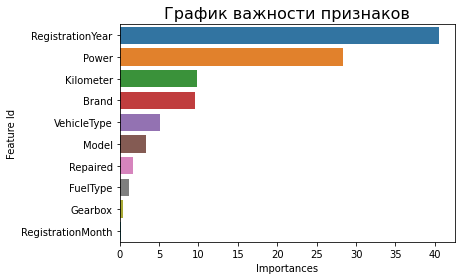

In [59]:
sns.barplot(x='Importances', y='Feature Id', data=fi)
plt.title ('График важности признаков', fontsize=16)

**Вывод**: 

1. В ходе предварительной обработки данных были удалены аномалии и нестанрдартные значения в признаках, заполнены пропуски и удалены дубликаты. 

2. В ходе проведенного исследования на очищенных данных были обучены и оценены 4 модели регрессии (модель линейной регресии, регрессии дерева решений, LightGBM и CatBoostRegressor), лучшие результаты среди которых показала модель CatBoostRegressor со значением стандартной ошшибки в размере 1733 (1695 - не тестовой выборке). При этом наибольшее влияние на прогноз имеет признак регистрации автомобиля, также достаточно важным признаком явлется показатель мощности автомобиля в лошадиных силах.